### Домашнее задание «Модели авторегрессии условной гетероскедантичности»
Выберите ряд из первого задания и постройте его модель GARCH.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt

from arch import arch_model

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


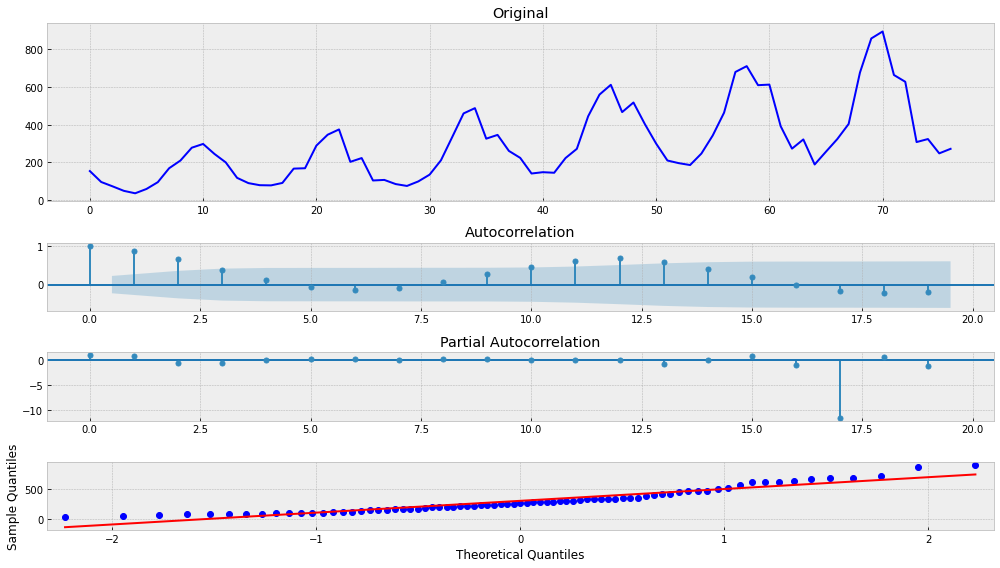

In [5]:
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")['Count']
tsplot(series)

In [6]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(7):
        for d in range(7):
            for j in range(7):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [7]:
aic, order, mdl = _get_best_model(series)


aic: 858.17298 | order: (3, 1, 2)


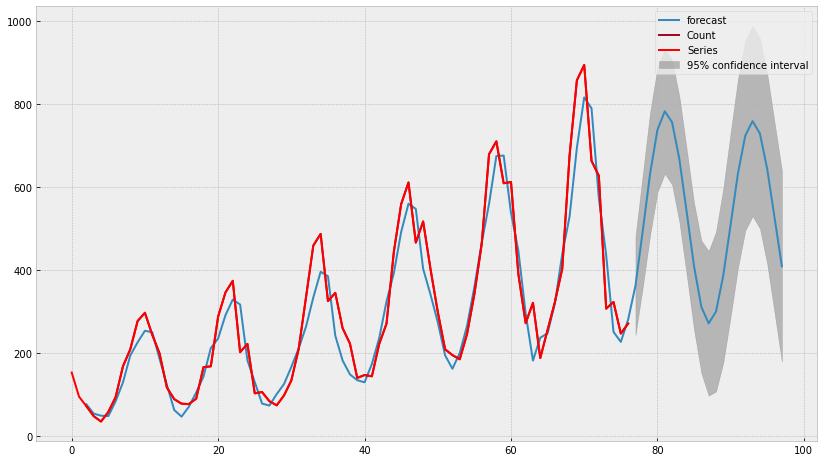

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(2, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [9]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]
series = series[12:] - series[:-12]

Results of Dickey-Fuller Test:
Test Statistic                 -5.290390
p-value                         0.000006
#Lags Used                      9.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


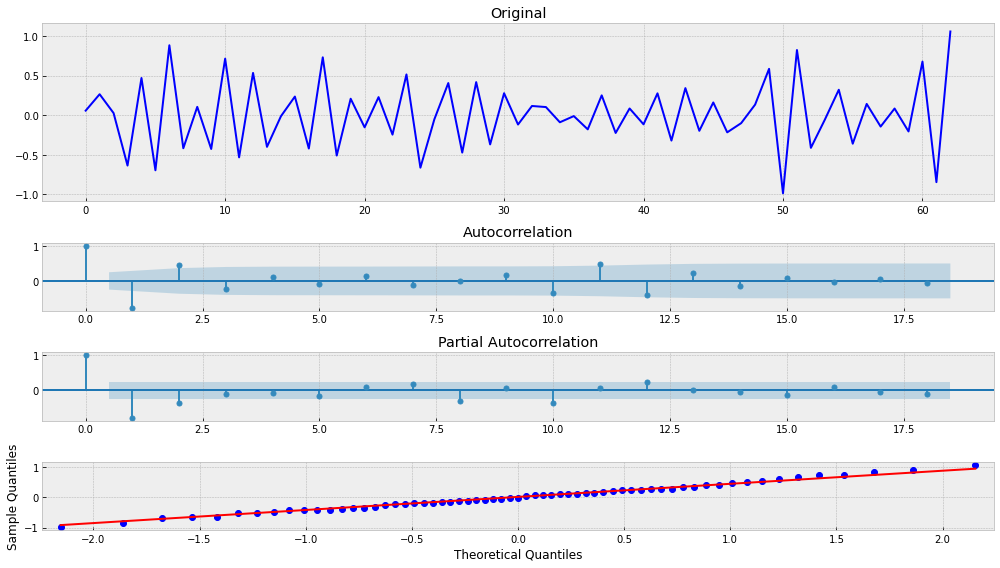

In [10]:
series = np.diff(series, 1)
tsplot(series)

In [11]:
order

(3, 1, 2)

In [12]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     59,   Neg. LLF: 144.78452072840247
Iteration:     10,   Func. Count:    113,   Neg. LLF: 30.01828582517724
Iteration:     15,   Func. Count:    163,   Neg. LLF: 29.850926898272323
Iteration:     20,   Func. Count:    213,   Neg. LLF: 29.32618362091235
Iteration:     25,   Func. Count:    263,   Neg. LLF: 29.1231191000521
Iteration:     30,   Func. Count:    317,   Neg. LLF: 29.094853894746155
Optimization terminated successfully    (Exit mode 0)
            Current function value: 29.0947616982867
            Iterations: 32
            Function evaluations: 347
            Gradient evaluations: 32
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -29.0948
Distribution:    

In [13]:
forecast = res.forecast(horizon=5)

In [14]:
series.shape

(63,)

In [15]:
series[-5:]

array([ 0.08468013, -0.20468933,  0.67777106, -0.8448283 ,  1.05757237])

In [16]:
forecast

In [17]:
forecast.residual_variance

,h.1,h.2,h.3,h.4,h.5
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
58,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN


Results of Dickey-Fuller Test:
Test Statistic                 -5.290390
p-value                         0.000006
#Lags Used                      9.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


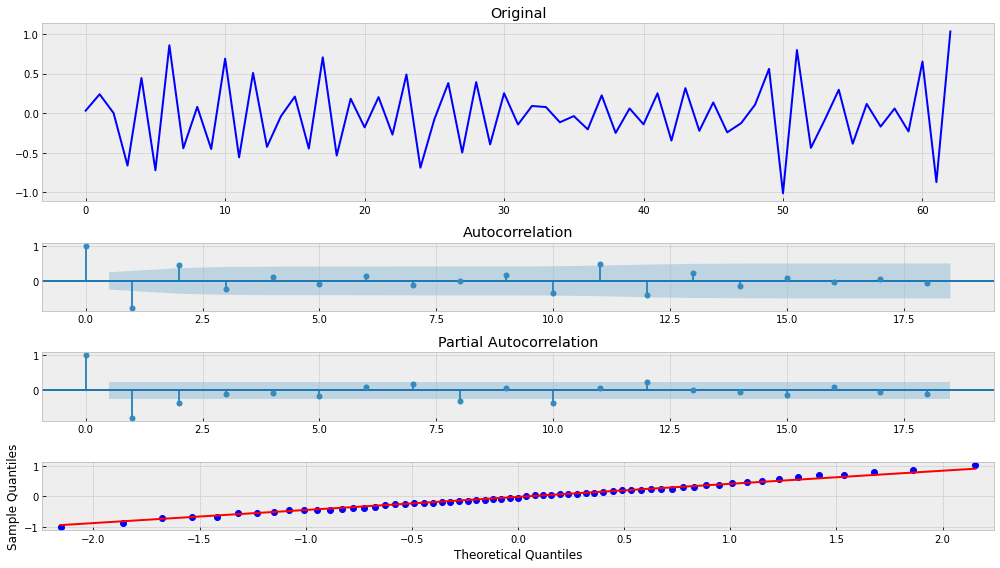

In [18]:
tsplot(res.resid)

#### Прогноз логистической регрессией


In [19]:
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")

In [20]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

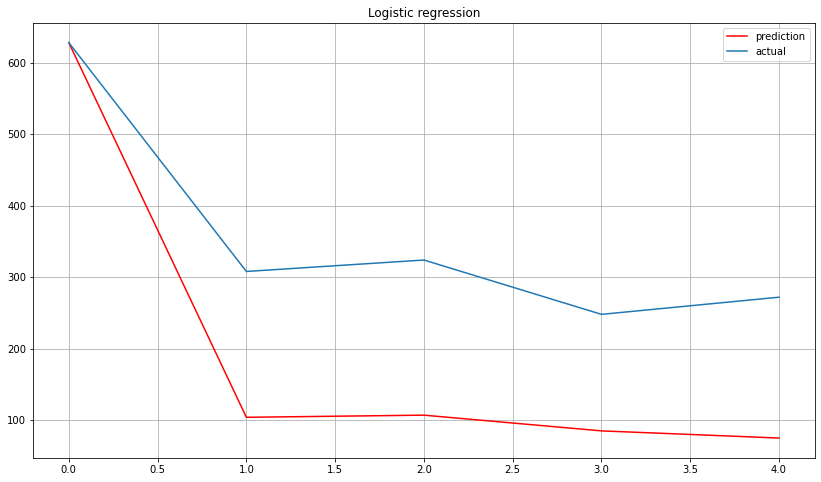

In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Logistic regression")
plt.grid(True);